# Effect of Different Block Sizes on Access Speed with Zstd and SquashFS

### Notebook Configurations

_Imports_

In [10]:
import os
import time 
import random
import getpass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

_Matplotlib Figures Styles_

In [11]:
plt.rcParams['figure.figsize'] = (10, 7) # for the size of matplotlib plots
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = "y"
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['grid.color'] = "#EEEEEE"

### Initial Hyphotesis

Small block sizes in compression can result in faster random reads, in this case, in a mounted SquashFS image.

### Initial variables

In the use case of a read-only filesystem (such as SquashFS), the decompression latency is a lot more important than compression latency. Thus, a high compression level for Zstd, which envolves slower compression speed but higher ratios and faster decompression, is optimal. 

* __Zstd compression level:__ 19

In [12]:
compression_level = 19 # high compression level for Zstandard (max is 22)

For this tests, the next files are used:

* __enwik9__: database based on Wikipedia composed of mostly english text in XML encoded with UTF-8. _Total size of file:_ 1GB

In [13]:
file = "enwik9"

For reproducible results, use __42__ as random seed.

In [14]:
random.seed(42)

_Helper functions_

In [15]:
def get_file_size(file):
    
    is_directory = os.popen(f"./is_directory.sh {file}").read().strip() # shell file to check if string corresponds to dir or file
    
    if(is_directory == "1"):
        size = os.popen(f"du -b {file}").read().split("\t")[0]
    else:
        size = os.popen(f"ls -l {file}").read().split(" ")[4]
    
    return int(size)


def get_speed(size, time):
    
    size_in_mb = size / (1024*1024)
    
    return round((size_in_mb/time), 2)


def get_compression_ratio(original, new):
    return original / new


## Effect of block sizes on Access Speed with Zstd and SquashFS

In summary, for each of the 5 block sizes a new SquashFS image is created from the enwik9 file. This image is then mounted in the _/mnt/squashfs-practice mountpoint_ from where it will be randomly accessed a N times. 

The following script calculates the time that it takes to complete the N lookups and stores the results in a Pandas DataFrame.

__Example Compression:__ _mksquashfs FILE FILE.sqsh -comp zstd -Xcompression-level 19 -b BLOCKSIZE_

In [ ]:
%%capture

block_sizes = ["4K", "16K", "64K", "256K", "1M"] # different block sizes, powers of 4

# New DataFrame
df_19 = pd.DataFrame()

filename = file.split(".")[0] # in case file has file format extension
size_original = get_file_size(file)

password = getpass.getpass() # Root user is needed to perform mounting/unmounting

n_lookups = 1000 # Number of random accesses to the file

for size in block_sizes:

    # -- COMPRESSION PROCESS -- #
    new_file = f"{filename}-{size}"

    compression_command = f"mksquashfs {file} {new_file}.sqsh -comp zstd -Xcompression-level {compression_level} -b {size} > /dev/null"

    # Compress and calculate time
    start_time = time.time()
    os.system(compression_command)
    compression_time = time.time() - start_time

    size_new = get_file_size(f"{new_file}.sqsh")

    # Calc metrics
    compression_ratio = get_compression_ratio(size_original, size_new)
    compression_speed = get_speed(size_original, compression_time)

    # -- MOUNTING PROCESS -- #
    mounting_command = f"sudo -S mount {new_file}.sqsh /mnt/squashfs-practice/ -t squashfs -o loop"
    os.system("echo %s | %s" % (password, mounting_command))
         

    # -- RANDOM ACCESS PATTERN -- #
    
    # Get number of characters in file
    n_characters = os.popen(f"wc -m /mnt/squashfs-practice/{filename}").read().split(" ")[0]
    n_characters = int(n_characters)
    
    # Create sample of n_lookups random positions
    positions = random.sample(range(0, n_characters), n_lookups)
    print(f"Total positions for lookup: {len(positions)}")
    
    fhand = open(f"/mnt/squashfs-practice/{filename}", "r", errors="ignore") # handle to file (read-only)
    
    start_time = time.time()
    for pos in positions:
        # for each position, change the handle and send 10 characters to another file
        fhand.seek(pos)
        print(f"10 characters in positions {pos}: ", fhand.read(10))
    access_time = time.time() - start_time
    
    # -- RESULTS SAVING -- #
    
    df_19 = df_19.append({
        "block_size": size,
        f"compression_ratio": compression_ratio,
        f"compression_speed": compression_speed,
        f"access_time": access_time
    }, ignore_index=True)
    
    # -- UNMOUNTING PROCESS -- #
    unmounting_command = f"sudo -S umount -l /mnt/squashfs-practice/"
    os.system(f"echo {password} | {unmounting_command}")

os.system(f"ls | grep {filename}- | xargs rm -R") # Code to remove the created files 

········


[sudo] password for carloscrg19: [sudo] password for carloscrg19: [sudo] password for carloscrg19: [sudo] password for carloscrg19: [sudo] password for carloscrg19: [sudo] password for carloscrg19: [sudo] password for carloscrg19: 

### Results

The obtained data stored in the main DataFrame.

In [17]:
df_19

,block_size,compression_ratio,compression_speed,access_time
0,4K,2.255570,52.86,0.235324
1,16K,2.734336,38.05,0.131258
2,64K,3.103864,26.74,0.280275
3,256K,3.401803,24.76,0.180000
4,1M,3.673055,22.38,0.163070


Creation of main graph. 

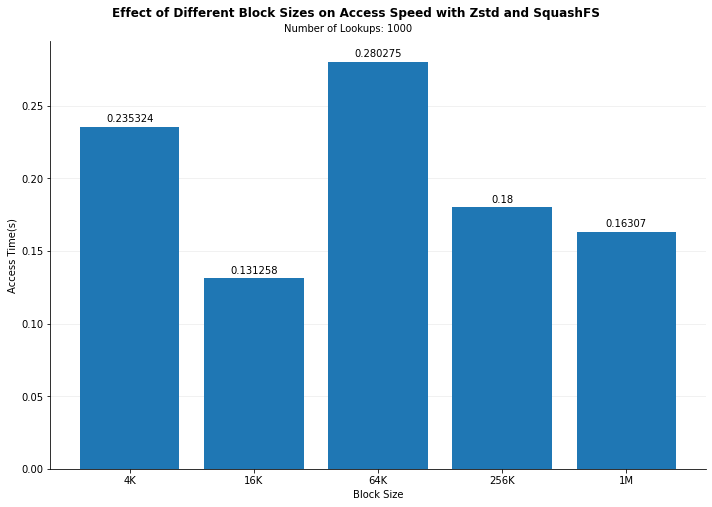

In [18]:
fig, ax = plt.subplots()

fig.suptitle("Effect of Different Block Sizes on Access Speed with Zstd and SquashFS", weight="bold", y=1)
fig.text(s="Number of Lookups: 1000", y=0.95, x=0.4)

compression_ratio_bars = ax.bar(x=df_19["block_size"], height=df_19["access_time"])

ax.set_ylabel("Access Time(s)")
ax.set_xlabel("Block Size")
ax.bar_label(compression_ratio_bars, padding=3)

fig.tight_layout()
plt.show()